In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [12]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.1, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=2, 
                              verbose=1)

In [13]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

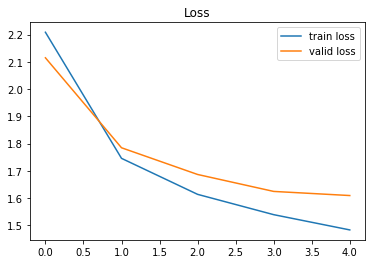

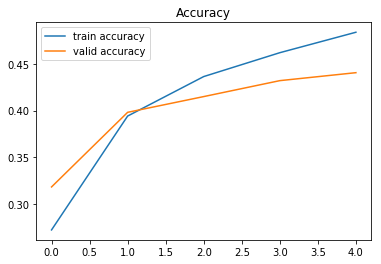

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
#LEARNING_RATE = 1e-3
#EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
#BATCH_SIZE = 1024 

LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.001,0.0001]
redice_lr_patient = [5,10]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=reduce_factor, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 8s 170us/step - loss: 1.1101 - acc: 0.6204 - val_loss: 1.4523 - val_acc: 0.4997
Epoch 19/20
50000/50000 [==============================] - 8s 161us/step - loss: 1.0880 - acc: 0.6287 - val_loss: 1.4505 - val_acc: 0.5014
Epoch 20/20
50000/50000 [==============================] - 8s 162us/step - loss: 1.0668 - acc: 0.6362 - val_loss: 1.4601 - val_acc: 0.4955
Numbers of exp: 2, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_la

50000/50000 [==============================] - 11s 217us/step - loss: 1.1818 - acc: 0.5925 - val_loss: 1.4715 - val_acc: 0.4825
Epoch 16/20
50000/50000 [==============================] - 9s 189us/step - loss: 1.1573 - acc: 0.6035 - val_loss: 1.4649 - val_acc: 0.4892
Epoch 17/20
50000/50000 [==============================] - 10s 193us/step - loss: 1.1343 - acc: 0.6103 - val_loss: 1.4638 - val_acc: 0.4838
Epoch 18/20
50000/50000 [==============================] - 9s 178us/step - loss: 1.1123 - acc: 0.6191 - val_loss: 1.4586 - val_acc: 0.4863
Epoch 19/20
50000/50000 [==============================] - 9s 186us/step - loss: 1.0897 - acc: 0.6294 - val_loss: 1.4552 - val_acc: 0.4920
Epoch 20/20
50000/50000 [==============================] - 10s 194us/step - loss: 1.0666 - acc: 0.6374 - val_loss: 1.4671 - val_acc: 0.4887
Numbers of exp: 4, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape          

50000/50000 [==============================] - 9s 179us/step - loss: 1.0914 - acc: 0.6123 - val_loss: 1.6724 - val_acc: 0.4412
Epoch 12/20
50000/50000 [==============================] - 9s 175us/step - loss: 1.0626 - acc: 0.6235 - val_loss: 1.5560 - val_acc: 0.4723
Epoch 13/20
50000/50000 [==============================] - 9s 175us/step - loss: 1.0281 - acc: 0.6348 - val_loss: 1.6248 - val_acc: 0.4402
Epoch 14/20
50000/50000 [==============================] - 9s 173us/step - loss: 0.9937 - acc: 0.6466 - val_loss: 1.5217 - val_acc: 0.4765
Epoch 15/20
50000/50000 [==============================] - 9s 178us/step - loss: 0.9572 - acc: 0.6635 - val_loss: 1.6459 - val_acc: 0.4462
Epoch 16/20
50000/50000 [==============================] - 9s 173us/step - loss: 0.9306 - acc: 0.6703 - val_loss: 1.5477 - val_acc: 0.4810
Epoch 17/20
50000/50000 [==============================] - 9s 175us/step - loss: 0.8979 - acc: 0.6818 - val_loss: 1.7182 - val_acc: 0.4443
Epoch 18/20
50000/50000 [==============

Epoch 8/20
50000/50000 [==============================] - 11s 228us/step - loss: 1.1666 - acc: 0.5890 - val_loss: 1.4910 - val_acc: 0.4744
Epoch 9/20
50000/50000 [==============================] - 11s 217us/step - loss: 1.1288 - acc: 0.6038 - val_loss: 1.6007 - val_acc: 0.4392
Epoch 10/20
50000/50000 [==============================] - 11s 230us/step - loss: 1.0825 - acc: 0.6189 - val_loss: 1.4964 - val_acc: 0.4749
Epoch 11/20
50000/50000 [==============================] - 11s 226us/step - loss: 1.0456 - acc: 0.6326 - val_loss: 1.5403 - val_acc: 0.4617
Epoch 12/20
50000/50000 [==============================] - 9s 173us/step - loss: 1.0090 - acc: 0.6476 - val_loss: 1.5719 - val_acc: 0.4603
Epoch 13/20
50000/50000 [==============================] - 10s 210us/step - loss: 0.9695 - acc: 0.6609 - val_loss: 1.4631 - val_acc: 0.4845
Epoch 14/20
50000/50000 [==============================] - 11s 230us/step - loss: 0.9374 - acc: 0.6715 - val_loss: 1.4955 - val_acc: 0.4840
Epoch 15/20
50000/50000

Epoch 5/20
50000/50000 [==============================] - 8s 169us/step - loss: 1.2953 - acc: 0.5431 - val_loss: 2.0546 - val_acc: 0.3085
Epoch 6/20
50000/50000 [==============================] - 9s 171us/step - loss: 1.2423 - acc: 0.5605 - val_loss: 2.1214 - val_acc: 0.3281
Epoch 7/20
50000/50000 [==============================] - 8s 170us/step - loss: 1.1896 - acc: 0.5791 - val_loss: 2.1134 - val_acc: 0.3288
Epoch 8/20
50000/50000 [==============================] - 9s 177us/step - loss: 1.1496 - acc: 0.5946 - val_loss: 1.9712 - val_acc: 0.3623
Epoch 9/20
50000/50000 [==============================] - 8s 169us/step - loss: 1.1115 - acc: 0.6095 - val_loss: 1.9920 - val_acc: 0.3623
Epoch 10/20
50000/50000 [==============================] - 10s 201us/step - loss: 1.0768 - acc: 0.6205 - val_loss: 1.9703 - val_acc: 0.3714
Epoch 11/20
50000/50000 [==============================] - 9s 180us/step - loss: 1.0379 - acc: 0.6342 - val_loss: 2.1283 - val_acc: 0.3499
Epoch 12/20
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 222us/step - loss: 1.9073 - acc: 0.3425 - val_loss: 1.9018 - val_acc: 0.3530
Epoch 2/20
50000/50000 [==============================] - 8s 167us/step - loss: 1.5962 - acc: 0.4390 - val_loss: 1.8573 - val_acc: 0.3766
Epoch 3/20
50000/50000 [==============================] - 9s 170us/step - loss: 1.4855 - acc: 0.4808 - val_loss: 1.7117 - val_acc: 0.3972
Epoch 4/20
50000/50000 [==============================] - 9s 170us/step - loss: 1.4113 - acc: 0.5069 - val_loss: 1.7111 - val_acc: 0.4075
Epoch 5/20
50000/50000 [==============================] - 8s 168us/step - loss: 1.3498 - acc: 0.5306 - val_loss: 1.6676 - val_acc: 0.4164
Epoch 6/20
50000/50000 [==============================] - 9s 174us/step - loss: 1.2989 - acc: 0.5471 - val_loss: 1.5521 - val_acc: 0.4563
Epoch 7/20
50000/50000 [==============================] - 9s 173us/step - loss: 1.2529 - acc: 0.5644 - val_loss: 2.0091 -

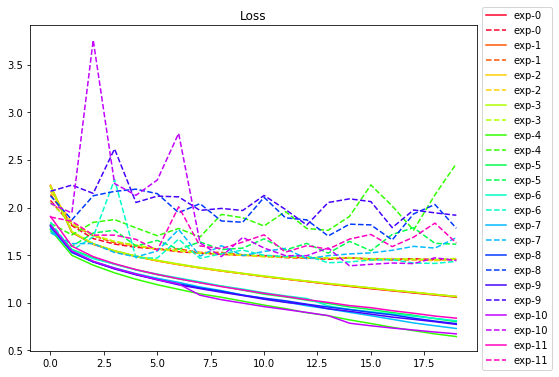

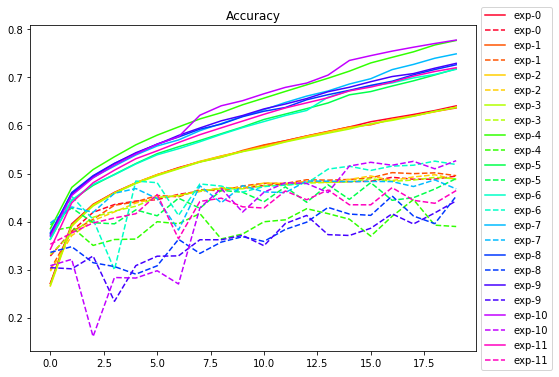

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()